# 課題10: 画像のエッジ抽出

Prewitt法、Sobel法、Canny法を用いて、エッジ抽出を行う。原画像として、課題2で使用した原画像（図1）を使用する。

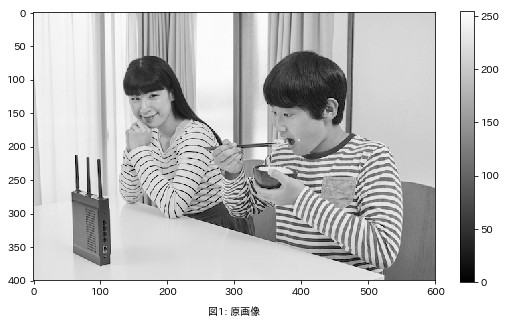

In [1]:
# 環境準備
%run -i prelude.ipynb

# 画像を読み込む
original = PIL.Image.open(IMAGE1_PATH)

# グレースケールに変換
original = np.array(original.convert(mode='L'))

# 表示
fig, ax = plt.subplots(figsize=(9, 5))
m = ax.imshow(original, cmap='gray', vmin=0, vmax=255)
fig.colorbar(m)
ax.text(0.5, -0.1, '図1: 原画像',
        transform=ax.transAxes,
        horizontalalignment='center',
        verticalalignment='top')

None

## Prewitt法
Prewitt法は、水平方向のエッジ抽出に表1のオペレータを、垂直方向のエッジ抽出に表2のオペレータを使う方法である。

<p style="text-align:center">表1: Prewittの水平方向オペレータ</p>
<table>
    <tbody>
        <tr><td>1</td><td>1</td><td>1</td></tr>
        <tr><td>0</td><td>0</td><td>0</td></tr>
        <tr><td>-1</td><td>-1</td><td>-1</td></tr>
    </tbody>
</table>

<p style="text-align:center">表2: Prewittの垂直方向オペレータ</p>
<table>
    <tbody>
        <tr><td>1</td><td>0</td><td>-1</td></tr>
        <tr><td>1</td><td>0</td><td>-1</td></tr>
        <tr><td>1</td><td>0</td><td>-1</td></tr>
    </tbody>
</table>

表1のオペレータを原画像に畳み込んだ結果を $G_y$、表2のオペレータを原画像に畳み込んだ結果を $G_x$ とする。図2に $\sqrt{\frac{G_x^2 + G_y^2}{2}}$ （参考文献1より）で得られた画像を示す。

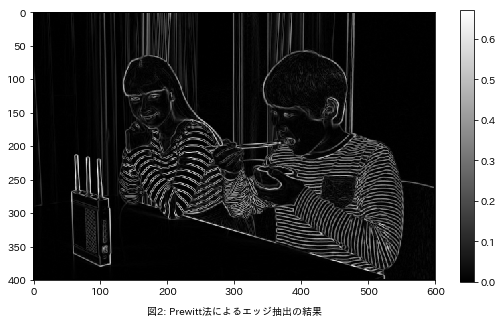

In [2]:
# scikit-image を使用する
import skimage

# Prewittのオペレータを適用
edge_prewitt = skimage.filters.prewitt(original)

# 表示
def edgeshow(img, title):
    fig, ax = plt.subplots(figsize=(9, 5))
    m = ax.imshow(img, cmap='gray', vmin=0)
    fig.colorbar(m)
    ax.text(0.5, -0.1, title,
            transform=ax.transAxes,
            horizontalalignment='center',
            verticalalignment='top')

edgeshow(edge_prewitt, '図2: Prewitt法によるエッジ抽出の結果')

## Sobel法
Sobel法は、Prewitt法のオペレータの中央画素を強調したもので、水平方向のエッジ抽出に表3のオペレータを、垂直方向のエッジ抽出に表4のオペレータを使う方法である。

<p style="text-align:center">表3: Sobelの水平方向オペレータ</p>
<table>
    <tbody>
        <tr><td>1</td><td>2</td><td>1</td></tr>
        <tr><td>0</td><td>0</td><td>0</td></tr>
        <tr><td>-1</td><td>-2</td><td>-1</td></tr>
    </tbody>
</table>

<p style="text-align:center">表4: Sobelの垂直方向オペレータ</p>
<table>
    <tbody>
        <tr><td>1</td><td>0</td><td>-1</td></tr>
        <tr><td>2</td><td>0</td><td>-2</td></tr>
        <tr><td>1</td><td>0</td><td>-1</td></tr>
    </tbody>
</table>

同様の計算方法で得られた画像を、図3に示す。

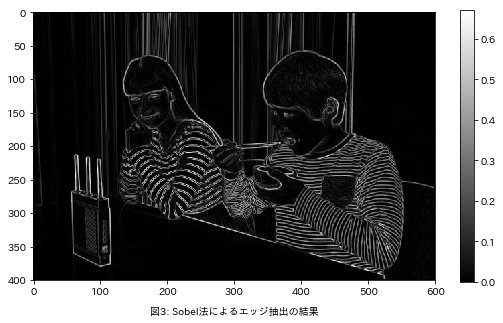

In [3]:
# Sobelのオペレータを適用
edge_sobel = skimage.filters.sobel(original)

# 表示
edgeshow(edge_sobel, '図3: Sobel法によるエッジ抽出の結果')

Prewitt法（図2）とSobel法（図3）を比較すると、ほぼ同じ結果が得られたように見える。

## Canny法
Canny法は、画像の畳み込みだけではなく、その結果を用いて輪郭線らしい線を抽出する方法で、エッジ抽出手法として良く用いられる方法である。

アルゴリズムを大まかに説明する（参考文献2）。

1. ガウシアンフィルタ（ガウス分布風に重み付け）で画像を平滑化する。これは課題9で行ったノイズ除去の効果がある。
2. 微分フィルタをかけ、水平方向、垂直方向それぞれのエッジを得る。ここではSobel法を用いる（参考文献3）。
3. 水平方向と垂直方向の微分結果から、各画素の勾配の大きさ（図2、図3を求めたときのように二乗和の平方根）と方向（arctan）を求める。
4. 各画素において、着目画素に隣接する、勾配方向と垂直な方向の画素（着目画素が上下方向の勾配を持っているなら、左右の画素）の勾配の大きさより、着目画素の勾配の大きさのほうが大きいならば、着目画素を残し、そうでないならば、着目画素を0にする。これにより、強いエッジを細線化し、それ以外を消すことができる。
5. 画素を3つに分類し、エッジとして残すか消すかを判断する。これにより、つながっている輪郭線は延長され、誤検出らしい輪郭は消される。
    - 画素値が最大閾値以上: 信頼度の高い輪郭なので残す（1にする）
    - 画素値が最小閾値未満: 信頼度が低い輪郭なので消す（0にする）
    - 画素値が最小閾値以上、最大閾値未満: 隣接する画素に信頼度の高い輪郭があれば1、ないならば0

scikit-imageによるCanny法の実装を用いて、原画像のエッジ抽出を行った結果を図4に示す。

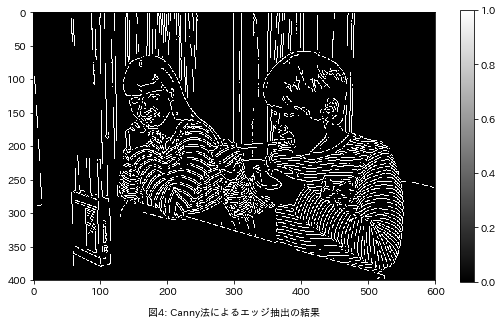

In [4]:
import skimage.feature # feature サブモジュールを読み込む

# Canny法によるエッジ抽出
edge_canny = skimage.feature.canny(original)

# 表示
edgeshow(edge_canny, '図4: Canny法によるエッジ抽出の結果')

Canny法（図4）では、はっきりとした線でエッジが得られることがわかった。Sobel法の結果を用いてエッジを抽出しているはずだが、図4を見ると、ルータの左下の部分のエッジが欠け、机側に線が出ている。これは、Sobel法の結果（図3）では強調されていたはずの線が抽出できておらず、逆になかったはずの線が得られていた。これは最大閾値が小さく（引数で指定しない場合、最小閾値は25.5、最大閾値は51となる）、小さな値でも残ってしまうためで、図5のように最大閾値を70まで引き上げると、机側の線は消える。

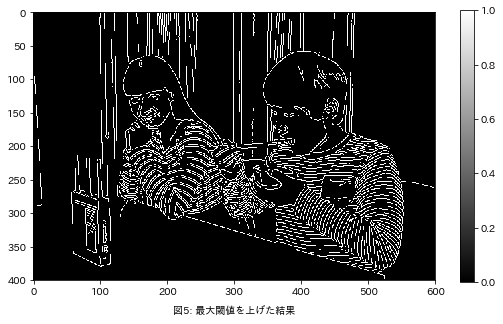

In [5]:
edge_canny2 = skimage.feature.canny(original, high_threshold=70)
edgeshow(edge_canny2, '図5: 最大閾値を上げた結果')

## 参考文献
1. [scikit-image v0.14.1 filters/edges.py の333-335行目](https://github.com/scikit-image/scikit-image/blob/v0.14.1/skimage/filters/edges.py#L333-L335)、2018年12月29日閲覧
2. [“【画像処理】Cannyエッジ検出器の原理・特徴・計算式  |  アルゴリズム雑記”](https://algorithm.joho.info/image-processing/canny-edge-detecter/)、2018年12月29日閲覧
3. [scikit-image v0.14.x skimage.feature.canny](http://scikit-image.org/docs/0.14.x/api/skimage.feature.html#canny)、2018年12月29日閲覧